$\underline{\text{Imports:}}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

$\underline{\text{Tensor KF class:}}$

In [2]:
class TensorKalmanFilter:
    def __init__(self, M, A, B, Q, R):
        """
        Initialize the Kalman Filter.

        Parameters:
        M (int): Dimension of the matrix state (M x M).
        A (numpy.ndarray): Transition tensor, shape (M, M, M, M).
        B (numpy.ndarray): Control tensor, shape (M, M, M).
        Q (numpy.ndarray): Process noise covariance, shape (M, M, M, M).
        R (numpy.ndarray): Observation noise covariance, shape (M, M).
        """
        self.M = M
        self.A = A
        self.B = B
        self.Q = Q  # Process noise covariance
        self.R = R  # Observation noise covariance
        self.theta = np.random.rand(M, M)  # Initial state estimate
        self.P = np.eye(M * M).reshape((M, M, M, M)) * 0.01  # Initial covariance estimate

        self.num_diag_q = M**2  # Number of diagonal elements in Q
        self.num_off_diag_q = (M**2 * (M**2 - 1)) // 2  # Off-diagonal elements in Q
        self.num_diag_r = M  # Number of diagonal elements in R
        self.num_off_diag_r = (M * (M - 1)) // 2  # Off-diagonal elements in R


    def predict(self, u_t):
        """Predict the next state."""
        theta_vec = self.theta.flatten()
        A_mat = self.A.reshape(self.M**2, self.M**2)
        theta_pred_vec = A_mat @ theta_vec
        Bu = np.einsum('ijk,k->ij', self.B, np.abs(u_t))
        theta_pred = theta_pred_vec.reshape((self.M, self.M)) + Bu

        P_pred = np.einsum('ijkl,lmno->ijko', self.A, self.P).reshape(self.M**2, self.M**2)
        P_pred = A_mat @ P_pred @ A_mat.T + self.Q.reshape(self.M**2, self.M**2)
        P_pred = P_pred.reshape(self.M, self.M, self.M, self.M)

        self.theta = theta_pred
        self.P = P_pred

    def update(self, y_t, u_t):
        """Update the state with the observation."""
        y_pred = self.theta @ u_t
        P_flat = self.P.reshape(self.M**2, self.M**2)
        H_flat = np.kron(np.abs(u_t).T, np.eye(self.M))
        epsilon = 1e-6
        S = H_flat @ P_flat @ H_flat.T + self.R + epsilon * np.eye(self.M)
        K_flat = P_flat @ H_flat.T @ np.linalg.inv(S)

        residual = y_t - y_pred
        theta_update_flat = self.theta.flatten() + K_flat @ residual
        theta_update = theta_update_flat.reshape((self.M, self.M))

        I = np.eye(self.M**2)
        K_H = K_flat @ H_flat
        P_update_flat = (I - K_H) @ P_flat
        P_update = P_update_flat.reshape(self.M, self.M, self.M, self.M)

        self.theta = theta_update
        self.P = P_update

    def log_likelihood(self, y, u):
        """Compute the log-likelihood of the observations given the parameters."""
        log_likelihood = 0
        theta = np.random.randn(self.M, self.M)
        P = np.eye(self.M**2).reshape(self.M, self.M, self.M, self.M) * 0.01
        for t in range(len(y)):
            self.predict(u[t])
            y_pred = theta @ u[t]
            P_flat = P.reshape(self.M**2, self.M**2)
            H_flat = np.kron(np.abs(u[t]).T, np.eye(self.M))
            epsilon = 1e-6
            S = H_flat @ P_flat @ H_flat.T + self.R + epsilon * np.eye(self.M)
            residual = y[t] - y_pred
            log_likelihood -= 0.5 * (np.log(np.linalg.det(S) + epsilon) +
                                     residual.T @ np.linalg.inv(S) @ residual +
                                     self.M * np.log(2 * np.pi))
            self.update(y[t], u[t])
        return log_likelihood

    def fit(self, y, u, initial_params):
        """
        Fit the model parameters (A, B, Q, R) by maximizing the log-likelihood.
        """
        def objective(params):
            A, B, Q_diag_log, Q_off_diag, R_diag_log, R_off_diag = self.unpack_params(params)
            self.A, self.B = A, B
            Q_diag = np.exp(Q_diag_log)  # Ensure positive diagonal
            R_diag = np.exp(R_diag_log)  # Ensure positive diagonal
            self.Q = self.rebuild_covariance(Q_diag, Q_off_diag)
            self.R = self.rebuild_covariance(R_diag, R_off_diag)
            return -self.log_likelihood(y, u)  # Negative log-likelihood for minimization

        result = minimize(objective, initial_params, method='L-BFGS-B')
        A, B, Q_diag_log, Q_off_diag, R_diag_log, R_off_diag = self.unpack_params(result.x)
        self.A, self.B = A, B
        Q_diag = np.exp(Q_diag_log)
        R_diag = np.exp(R_diag_log)
        self.Q = self.rebuild_covariance(Q_diag, Q_off_diag)
        self.R = self.rebuild_covariance(R_diag, R_off_diag)
        return result

    def unpack_params(self, params):
        """Unpack parameter vector into A, B, Q_diag (log), Q_off_diag, R_diag (log), R_off_diag."""
        A = params[:self.M**4].reshape(self.M, self.M, self.M, self.M)
        B = params[self.M**4:self.M**4 + self.M**3].reshape(self.M, self.M, self.M)
        Q_diag_log = params[self.M**4 + self.M**3:self.M**4 + self.M**3 + self.num_diag_q]
        Q_off_diag = params[self.M**4 + self.M**3 + self.num_diag_q:self.M**4 + self.M**3 + self.num_diag_q + self.num_off_diag_q]
        R_diag_log = params[-(self.num_diag_r + self.num_off_diag_r):-self.num_off_diag_r]
        R_off_diag = params[-self.num_off_diag_r:]
        return A, B, Q_diag_log, Q_off_diag, R_diag_log, R_off_diag


    def rebuild_covariance(self, diag_log, off_diag):
        """Rebuild a full covariance matrix from log-diagonal and off-diagonal elements."""
        diag = np.exp(diag_log)  # Exponentiate diagonal elements
        cov = np.diag(diag)  # Diagonal matrix
        cov[np.triu_indices_from(cov, k=1)] = off_diag  # Upper triangular off-diagonals
        cov += cov.T - np.diag(diag)  # Symmetrize
        return cov




$\underline{\text{Data Generation:}}$

In [3]:
# Generate a new random tensor A and normalize it
M = 3  # Dimensions of the state matrix
np.random.seed(42)  # For reproducibility

# Generate a random tensor A
A_random = np.random.rand(M, M, M, M)

# Normalize A to ensure stability (spectral normalization)
A_reshaped = A_random.reshape(M**2, M**2)
max_eigenvalue = np.max(np.abs(np.linalg.eigvals(A_reshaped)))
A_normalized = A_random / (max_eigenvalue + 1e-6)  # Adding a small epsilon to avoid divide-by-zero

# Verify normalization
A_reshaped_normalized = A_normalized.reshape(M**2, M**2)
normalized_max_eigenvalue = np.max(np.abs(np.linalg.eigvals(A_reshaped_normalized)))

# Output results
print("Max eigenvalue of original A:", max_eigenvalue)
print("Max eigenvalue of normalized A:", normalized_max_eigenvalue)


Max eigenvalue of original A: 4.161869552964666
Max eigenvalue of normalized A: 0.9999997597234276


In [4]:
# Simulation parameters
time_steps = 1000

# Generate true dynamics
true_A = 0.9*A_reshaped_normalized.reshape(M, M, M, M)  # Identity dynamics for simplicity
true_B = np.random.rand(M, M, M) * 0.01  # Small control impact
true_Q = np.eye(M**2).reshape(M, M, M, M) * 0.01  # Small process noise
true_R = np.eye(M) * 0.05  # Observation noise

# Initialize true state and control
true_theta = np.random.rand(M, M)+ np.eye(M)
u_t = np.random.rand(time_steps, M)   # Control inputs
y_t = []  # Observations
true_states = [true_theta]  # True states

# Generate true trajectory and observations
for t in range(time_steps):
    true_theta = (np.einsum('ijkl,kl->ij', true_A, true_theta) +
                  np.einsum('ijk,k->ij', true_B, u_t[t]) +
                  np.random.multivariate_normal(np.zeros(M**2), true_Q.reshape(M**2, M**2)).reshape(M, M)) 
    true_states.append(true_theta)
    obs = np.dot(true_theta, u_t[t]) + np.random.multivariate_normal(np.zeros(M), true_R)
    y_t.append(obs)

y_t = np.array(y_t)

''

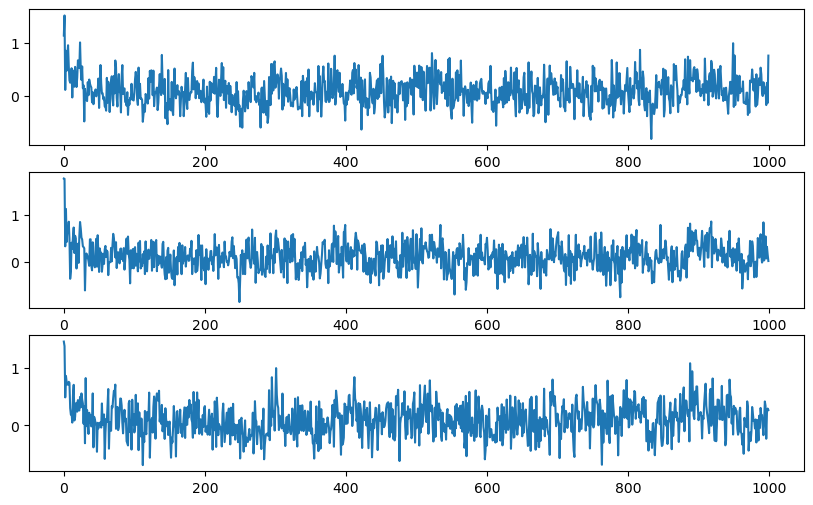

In [8]:
fig, ax = plt.subplots(3, 1, figsize=(10, 6))
for i in range(M):
    ax[i].plot(y_t[:, i], label=f"Observed {i}")
;

$\underline{\text{Fitting:}}$

In [9]:
kf = TensorKalmanFilter(M, np.random.rand(M, M, M, M), np.random.rand(M, M, M), np.random.rand(M, M, M, M), np.random.rand(M, M))

In [10]:
# Extract the diagonal elements
true_Q_diag = np.einsum('ijij->ij', true_Q)  # Diagonal of 4D tensor
true_R_diag = np.diag(true_R)  # Diagonal of 2D matrix

# Extract off-diagonal elements of Q
# Reshape Q to 2D (M^2 x M^2) and use triu_indices
true_Q_reshaped = true_Q.reshape(M**2, M**2)
true_Q_off_diag = true_Q_reshaped[np.triu_indices(M**2, k=1)]  # Upper triangular off-diagonals

# Extract off-diagonal elements of R
true_R_off_diag = true_R[np.triu_indices(M, k=1)]

# Construct initial parameters
# Construct initial parameters
initial_params = np.concatenate([
    true_A.flatten() + 0.1 * np.random.randn(true_A.flatten().shape[0]),  # Flattened A
    true_B.flatten() + 0.1 * np.random.randn(true_B.flatten().shape[0]),  # Flattened B
    np.log(true_Q_diag).flatten() + 0.1 * np.random.randn(true_Q_diag.flatten().shape[0]),  # Log of Q diagonals
    true_Q_off_diag.flatten() + 0.1 * np.random.randn(true_Q_off_diag.flatten().shape[0]),  # Off-diagonal elements of Q
    np.log(true_R_diag).flatten() + 0.1 * np.random.randn(true_R_diag.flatten().shape[0]),  # Log of R diagonals
    true_R_off_diag.flatten() + 0.1 * np.random.randn(true_R_off_diag.flatten().shape[0])  # Off-diagonal elements of R
])

# Fit the model
kf = TensorKalmanFilter(M, true_A, true_B, true_Q, true_R)
result = kf.fit(y_t, u_t, initial_params)

In [11]:
print("Estimated A:", kf.A)
print("Estimated B:", kf.B)
print("Estimated Q:", kf.Q)
print("Estimated R:", kf.R)

Estimated A: [[[[-0.02608152  0.30220026  0.21432096]
   [-0.06916977  0.06148101 -0.0435638 ]
   [ 0.12226811  0.0427697   0.09434283]]

  [[ 0.18932239  0.00988546  0.28603781]
   [ 0.02817259  0.2111096   0.09183395]
   [ 0.17563291  0.15321615  0.11231706]]

  [[-0.03501223  0.0066227   0.29126879]
   [ 0.16870925  0.00121602 -0.20260511]
   [ 0.07735562  0.14102319  0.01820203]]]


 [[[ 0.16405658  0.21573032  0.10907486]
   [ 0.17595187 -0.14320136 -0.0200526 ]
   [ 0.43560449  0.2462385   0.21159705]]

  [[ 0.10182105  0.06265941 -0.0903465 ]
   [ 0.07123013  0.02260138  0.23523104]
   [ 0.01220382  0.03198846  0.09896988]]

  [[ 0.06288728 -0.05427135  0.02904824]
   [ 0.17247595  0.16585064  0.25796462]
   [ 0.23082401  0.25047019  0.20363818]]]


 [[[ 0.19898824 -0.04252321  0.03024527]
   [-0.06211144  0.12607066  0.05563683]
   [ 0.08714589 -0.09182823  0.28089668]]

  [[ 0.13988039  0.11644662  0.03605522]
   [-0.04688922  0.19583423 -0.05332833]
   [ 0.25690259 -0.0490941

$\underline{\text{Data Filtering:}}$

In [12]:
kf = TensorKalmanFilter(M, 
                        true_A, 
                        true_B, 
                        true_Q, 
                        true_R)

In [13]:
# Run Kalman filter
predicted_states = []
filtered_states = []
kf_states = kf.theta.copy()

for t in range(time_steps):
    kf.predict(u_t[t])
    predicted_states.append(kf.theta.copy())
    kf.update(y_t[t], u_t[t])
    filtered_states.append(kf.theta.copy())

filtered_states = np.array(filtered_states)


$\underline{\text{Plots:}}$

In [14]:
import numpy as np
import os 
import pandas as pd
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import curve_fit
plt.style.use('default')
cmap = get_cmap('inferno')
folder = "Thesis_Pictures/"
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize":10,
    "font.size":10,
    "axes.titlesize" :10,
    'text.latex.preamble': r'\usepackage{amsfonts, amsmath, bm}\usepackage[T1]{fontenc}\usepackage{tgbonum}',
    # Make the legend/label fonts a little smaller
    "legend.fontsize":9,
    "xtick.labelsize":9,
    "ytick.labelsize":9
}
def set_size(width='thesis', fraction=1, subplots=(1, 2)):
    """Set figure dimensions to avoid scaling in LaTeX.
    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 483.6968
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width
    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27
    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2
    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    return (fig_width_in+.3, fig_height_in)
plt.rcParams.update(tex_fonts)
#columnwidth = 510
columnwidth = 483.6968 #thèse

fw3,fh3 = set_size('thesis', subplots=(3,3))


latex_path = r'/Library/TeX/texbin'
os.environ['PATH'] += os.pathsep + latex_path

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

/var/folders/x4/sqc7r28j1qggd73l6jk91xnr0000gn/T/ipykernel_22455/3728371236.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('inferno')


In [15]:
# Plot results
fig, axes = plt.subplots(M, M, figsize=(fw3,fw3), layout='constrained')
for i in range(M):
    for j in range(M):
        ax = axes[i, j]
        ax.plot(range(time_steps), [state[i, j][:100] for state in true_states[:-1]], color='black', label="True")
        ax.plot(range(time_steps), [state[i, j][:100] for state in filtered_states], color='red', label="Filtered", linestyle='--')
        ax.plot(range(time_steps), [state[i, j][:100] for state in predicted_states], color='navy', label="Predicted", linestyle='--')
        ax.set_title(f"$\Theta_{{{i+1}{j+1}}}$")
        #ax.legend()
        ax.grid()

plt.tight_layout()
plt.savefig("Tensor_Kalman_Filter_test_0.pdf", bbox_inches='tight', transparent=True)

IndexError: invalid index to scalar variable.

In [ ]:
# Plot results
fig, axes = plt.subplots(M, M, figsize=(fw3,fw3), layout='constrained')
for i in range(M):
    for j in range(M):
        ax = axes[i, j]
        ax.hist( [state[i, j] for state in true_states[:-1]], color='black', label="True")
        ax.hist( [state[i, j] for state in filtered_states], color='red', label="Filtered", linestyle='--')
        ax.hist( [state[i, j] for state in predicted_states], color='navy', label="Predicted", linestyle='--')
        ax.set_title(f"$\Theta_{{{i+1}{j+1}}}$")
        #ax.legend()
        ax.grid()

plt.tight_layout()
plt.savefig("Tensor_Kalman_Filter_test_0.pdf", bbox_inches='tight', transparent=True)

In [ ]:
from scipy import stats

# Perform t-test
t_stat, p_value = stats.ttest_ind(filtered_states, true_states[:-1], axis=0)

# Print results
print("T-statistic:", t_stat)
print("P-value:", p_value)
